In [12]:
import sys
sys.path.append('../')

import matlab.engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from skopt.sampler import Lhs
from skopt.space import Space
import math
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from scipy.stats import norm
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from sklearn.neighbors import KernelDensity
from numpy.random import uniform
from sklearn.preprocessing import MinMaxScaler
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from Hypervolume import HyperVolume
import optproblems.zdt
import ConfigSpace as CS
import sys
import matplotlib.pyplot as plt
from DT import ML
from Problem import Problem
from MOTPE import MOTPE

eng = matlab.engine.start_matlab()
random_seed = 1990

In [13]:
def plot_pf(non_dominated_points, solutions):
    
    m = np.mean(non_dominated_points, axis=1)
    std =  np.sqrt(np.var(non_dominated_points, axis=1))
    max_data = m+std #np.max(non_dominated_points, axis=1)
    min_data = m-std #np.min(non_dominated_points, axis=1)
    
    ells = [Ellipse(xy=[m[i,0], m[i,1]], 
                    width=np.abs(max_data[i,0]-min_data[i,0]), 
                    height=np.abs(max_data[i,1]-min_data[i,1]))
            for i in range(m.shape[0])]

    fig, ax = plt.subplots(figsize=(10,10))

    index = 0
    for e in ells:
        ax.add_patch(e)
        
        if index==0:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor="peachpuff", edgecolor='silver', label='Uncertainty')
        else:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor="peachpuff", edgecolor='silver')
        index+=1
        
#         e.set_edgecolor('silver')
    max_axes = np.max([max_data[:,0], max_data[:,1]])
#     ax.set_xlim(0, max_axes+.5)
#     ax.set_ylim(0, max_axes+.5)

    ax.scatter(m[:, 0], m[:, 1], color='k', s=50, 
               zorder=len(ells)+1, label="Observed PF")
#     ax.scatter(tf[:,0], tf[:,1], label="Optimal PF")
    ax.scatter(solutions[:, 0], solutions[:, 1], color='orange', marker='+', zorder=len(ells)+2, label="Solutions")
    ax.legend()
    return ax

In [14]:
def compute_hypervolume(m, referencePoint):
    hv = HyperVolume(referencePoint)
    volume = hv.compute(m)
    return volume

In [15]:
def pareto_front(points, level=0, index=False):

    points = points.copy()
    ranks = np.zeros(len(points))
    r = 0
    c = len(points)
    while c > 0:
        extended = np.tile(points, (points.shape[0], 1, 1))
        dominance = np.sum(np.logical_and(
            np.all(extended <= np.swapaxes(extended, 0, 1), axis=2),
            np.any(extended < np.swapaxes(extended, 0, 1), axis=2)), axis=1)
        points[dominance == 0] = 1e9  # mark as used
        ranks[dominance == 0] = r
        r += 1
        c -= np.sum(dominance == 0)
    if index:
#         return ranks
        return [i for i in range(len(ranks)) if ranks[i] == level] 
    else:    
        ind = [i for i in range(len(ranks)) if ranks[i] == level]
        return points[ind]

In [16]:
def acquisition_function(candidates, model, Z_min, score_tpe=0):
    BK = np.asarray([np.ones(candidates.shape[0])])
    BK = matlab.double(np.transpose(BK).tolist())

    [SK_gau, SK_gau_mse, det_mse]  = eng.SKpredict_new(model, matlab.double(candidates.tolist()), BK, 
                                              matlab.double(np.asarray([random_seed]).tolist()),
                                              nargout=3)
    SK_gau = np.asarray(SK_gau)
    det_mse = np.asarray(det_mse)
    mse = np.sqrt(np.abs(det_mse))
    
    mei = (Z_min-SK_gau) * norm.cdf((Z_min-SK_gau)/mse,0,1) + mse * norm.pdf((Z_min-SK_gau)/mse,0,1) + score_tpe
#     print("mei", mei, mei.shape)
    return -mei[:,0]

In [17]:
eps = sys.float_info.epsilon


seed                = random_seed   #args.seed
num_variables       = 5     #args.num_variables
num_initial_samples = 11*num_variables-1    #args.num_initial_samples
num_max_evals       = 100   #args.num_max_evals
num_objectives      = 2     #args.num_objectives
k                   = 1     #args.k
num_candidates      = 1000    #args.num_candidates
init_method         = 'random' #args.init_method
gamma               = 0.1   #args.gamma
benchmark_name      = "banana" #args.benchmark_name
replications        = 10
# LOAD DATA

dataset = fetch_openml(name=benchmark_name)
X = dataset.data
y = dataset.target
# X_train and y_train will be used in an internal cross validation process for the HPO
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=seed)

base_configuration  = {
    'num_objectives': num_objectives,
    'num_variables': num_variables,
    'replications': replications,
    'k': k,
    'seed': seed}

f       = ML(benchmark_name, X_train, y_train, X_test, y_test, base_configuration)
cs      = f.make_cs(CS.ConfigurationSpace(seed=seed))
problem = Problem(f, cs)
solver  = MOTPE(seed=seed)

cs, i = solver.init_model(
    {'num_initial_samples': num_initial_samples,
     'num_max_evals': num_max_evals,
     'init_method': init_method,
     'num_candidates': num_candidates,
     'scalarize':False,
     'gamma': gamma},
        problem)
# data = solver.history_replications()
# X = solver.get_X()
hv_history = []
W = solver.get_weights_scalarization()

Sampling initial points: 
     0.0 %
     1.85 %
     3.7 %
     5.56 %
     7.41 %
     9.26 %
     11.11 %
     12.96 %
     14.81 %
     16.67 %
     18.52 %
     20.37 %
     22.22 %
     24.07 %
     25.93 %
     27.78 %
     29.63 %
     31.48 %
     33.33 %
     35.19 %
     37.04 %
     38.89 %
     40.74 %
     42.59 %
     44.44 %
     46.3 %
     48.15 %
     50.0 %
     51.85 %
     53.7 %
     55.56 %
     57.41 %
     59.26 %
     61.11 %
     62.96 %
     64.81 %
     66.67 %
     68.52 %
     70.37 %
     72.22 %
     74.07 %
     75.93 %
     77.78 %
     79.63 %
     81.48 %
     83.33 %
     85.19 %
     87.04 %
     88.89 %
     90.74 %
     92.59 %
     94.44 %
     96.3 %
     98.15 %


In [18]:
#Optimization procedure
for it in range(num_max_evals):   
    print("Iteration: ", it, "/", num_max_evals)
    
    data = solver.history_replications()
    X = solver.get_X()

    #Prepare de optimization
    Y_mean=np.zeros(data.shape[0])
    Vhat=np.zeros(data.shape[0])
    B = np.asarray([np.ones(data.shape[0])])

    #### Scalarization
    # Randomly select a point
    weight = W[np.random.randint(0, W.shape[0]),:]
    
    for i in range(data.shape[0]):
        point = np.asarray(data[i])
        pcheby_term1 = np.max(point * np.tile(weight, (replications,1)), axis=1)
        pcheby_term2 = np.sum(point * np.tile(weight, (replications,1)), axis=1)
        pcheby = pcheby_term1 + 0.05*pcheby_term2
        Y_mean[i] = np.mean(pcheby);
        Vhat[i] = np.var(pcheby)/replications;
    Vhat = np.asarray([Vhat]).T
    #Normalize objectives
    scaler = MinMaxScaler()
    Y_mean = scaler.fit_transform(np.asarray([Y_mean]).T)
    
    
#     print(X.shape, Y_mean.shape, B.T.shape, Vhat.shape)
    
    X_matlab = matlab.double(X.tolist())
    Y_matlab = matlab.double(Y_mean.tolist())
    B = matlab.double(np.transpose(B).tolist())
    Vhat = matlab.double(Vhat.tolist())

    skriging_model_2 = eng.SKfit_new(X_matlab,Y_matlab, B, Vhat, 2, 3, 
                                     matlab.double(np.asarray([random_seed]).tolist()), nargout=1);
    
#     ######### SELECTION ########
    # Select the best point and evaluate it wh SK
    index_best = Y_mean.argmin(axis=0)[0]
    X_matlab = matlab.double(np.asarray(X[index_best,:]).tolist())

    [SK_gau, SK_gau_mse]  = eng.SKpredict_new(skriging_model_2, X_matlab, 
                                              matlab.double(np.asarray([1]).tolist()), 
                                              matlab.double(np.asarray([random_seed]).tolist()),
                                              nargout=2);
    SK_gau_array = np.asarray(SK_gau)
    sample = solver.sample(cs)
    

    # Select the point sampled from l that maximize the MEI
    meis = acquisition_function(sample, skriging_model_2, SK_gau_array)
    best_mei = meis.argmin(axis=0)
    pos = sample[best_mei]
    print(pos)
    solver.add_infill_point(problem, pos, i)
    
#     m = np.mean(data, axis=1)
#     pf = pareto_front(m, index=True)
#     pf = data[pf]
#     volume=compute_hypervolume(np.mean(pf, axis=1), [1, 0])
#     hv_history.append(volume)
#     plot_evolution(X, XK, skriging_model_2, truthk, it)

Iteration:  0 / 100
[1.30000000e+01 3.70873829e-03 6.00000000e+00 1.00000000e+00
 1.00000000e+00]
Iteration:  1 / 100
[1.00000000e+01 7.75003904e-04 6.00000000e+00 3.00000000e+00
 2.00000000e+00]
Iteration:  2 / 100
[1.10000000e+01 4.84784425e-03 9.00000000e+00 2.00000000e+00
 2.00000000e+00]
Iteration:  3 / 100
[13.          0.05564658  8.          1.          1.        ]
Iteration:  4 / 100
[1.60000000e+01 7.46731804e-03 6.00000000e+00 2.00000000e+00
 2.00000000e+00]
Iteration:  5 / 100
[18.          0.03168351  5.          3.          1.        ]
Iteration:  6 / 100
[20.          0.03961572  2.          3.          1.        ]
Iteration:  7 / 100
[1.50000000e+01 2.49980427e-04 3.00000000e+00 3.00000000e+00
 2.00000000e+00]
Iteration:  8 / 100
[1.6000000e+01 1.1576719e-02 4.0000000e+00 2.0000000e+00 1.0000000e+00]
Iteration:  9 / 100
[1.00000000e+01 4.07845723e-03 3.00000000e+00 3.00000000e+00
 2.00000000e+00]
Iteration:  10 / 100
[1.70000000e+01 2.40533421e-04 3.00000000e+00 1.00000

[1.7000000e+01 1.7488384e-03 1.0000000e+00 3.0000000e+00 1.0000000e+00]
Iteration:  94 / 100
[0.         0.03215986 1.         1.         1.        ]
Iteration:  95 / 100
[0.        0.0230047 8.        3.        2.       ]
Iteration:  96 / 100
[0.         0.04612847 3.         2.         1.        ]
Iteration:  97 / 100
[12.          0.02027281  5.          3.          2.        ]
Iteration:  98 / 100
[1.         0.01379049 2.         1.         1.        ]
Iteration:  99 / 100
[11.          0.02757023  1.          1.          2.        ]


In [ ]:
# lhs = solver.get_X()
# lhs = lhs[:num_initial_samples,:]

# df = pd.DataFrame(lhs)
# df.to_csv("lhs_ML.csv")

In [19]:
rep = solver.history_replications()
mmm = pd.DataFrame(rep.reshape(rep.shape[0]*rep.shape[1],2))
mmm.to_csv("replications_GP_MOTPE_DT.csv")

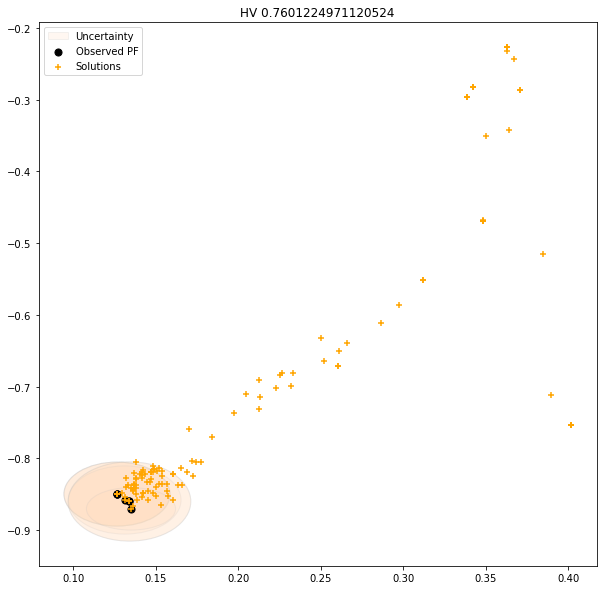

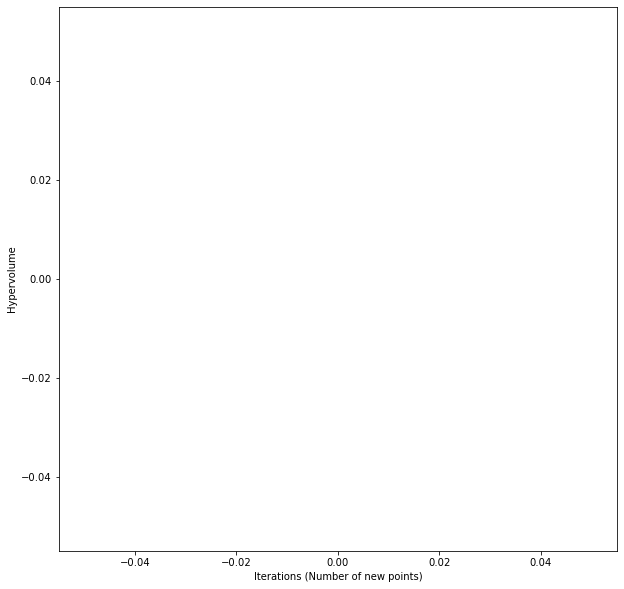

In [20]:
data = solver.history_replications()
m = np.mean(data, axis=1)
pf = pareto_front(m, index=True)
pf = data[pf]
volume=compute_hypervolume(np.mean(pf, axis=1), [1, 0])

# tf = optimal_set()
ax = plot_pf(pf, m)
plt.title("HV "+str(volume))
# plt.ylim([0, 1])
# plt.xlim([0, 1])
plt.legend()


fig, ax = plt.subplots(figsize=(10,10))
plt.plot(hv_history)
plt.xlabel("Iterations (Number of new points)")
plt.ylabel("Hypervolume")


# Save the exploration in validation
df = pd.DataFrame(m)
df.to_csv("exploration_GP_MOTPE_val_DT.csv")

# Save the exploration in test
m = solver.test_evaluations()
df = pd.DataFrame(m)
df.to_csv("exploration_GP_MOTPE_test_DT.csv")